In [60]:
from logging import raiseExceptions
from tokenize import Double
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import torch
torch.manual_seed(125)
import random
random.seed(125)
import torch_f as torch_f
from modelovae import Node, GRASSEncoder, GRASSDecoder, deserialize
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import statistics


In [41]:
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

def count_fn(f):
    def wrapper(*args, **kwargs):
        wrapper.count += 1
        return f(*args, **kwargs)
    wrapper.count = 0
    return wrapper

In [42]:
def traverseleaves(root, leaves):
    if root is not None:
        traverseleaves(root.left, leaves)
        if root.is_leaf():
            leaves.append(root)
        traverseleaves(root.right, leaves)
        return

def traverse(root):
        if root is not None:
            traverse(root.left)
            root.radius=root.radius.reshape(4)
            traverse(root.right)
            return

def traverseradius(root, rlist):
    if root is not None:
        traverseradius(root.left, rlist)
        rlist.append(root.radius[3])
        print("radius", root.radius[3])
        traverseradius(root.right, rlist)
        return 

def traversefeatures(root, features):
    if root is not None:
        traversefeatures(root.left, features)
        features.append(root.radius[3].cpu().item())
        traversefeatures(root.right, features)
        return features

def traversefeatures2(root, features):
    if root is not None:
        traversefeatures2(root.left, features)
        features.append(root.radius[0][3].cpu().item())
        traversefeatures2(root.right, features)
        return features          

def traverse_conexiones(root, tree):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            traverse_conexiones(root.left, tree)
            if root.right is not None:
                tree.append((root.data, root.right.data))
            if root.left is not None:
                tree.append((root.data, root.left.data))
            traverse_conexiones(root.right, tree)
            return tree

@count_fn
def createNode(data, radius,left = None, right = None):
        """
        Utility function to create a node.
        """
        return Node(data, radius, left, right)
 


def read_tree(filename, dir):
    with open('./' +dir +'/' +filename, "r") as f:
        byte = f.read() 
        return byte

def numerar_nodos(root, count):
    if root is not None:
        numerar_nodos(root.left, count)
        root.data = len(count)
        count.append(1)
        numerar_nodos(root.right, count)
        return 

def number_nodes(data_loader, batch_size):
    n_no = []
    qzero = 0
    qOne = 0
    qtwo = 0
    for batch in data_loader:
        for tree in batch:
            tree = tree[0]
            count = []
            n = tree.count_nodes(tree, count)
            n_no.append(len(n))
            li = []
            tree.traverseInorderChilds(tree, li)
            zero = [a for a in li if a == 0]
            one = [a for a in li if a == 1]
            two = [a for a in li if a == 2]
            qzero += len(zero)
            qOne += len(one)
            qtwo += len(two)

    nprom = np.mean(n_no)
    qzero /= len(data_loader)*batch_size
    qOne /= len(data_loader)*batch_size
    qtwo /= len(data_loader)*batch_size
    if round(qzero) == 0:
        qzero = 1
    if round(qOne) == 0:
        qOne = 1
    if round(qtwo) == 0:
        qtwo = 1
    mult = torch.tensor([1/round(qzero),1/round(qOne),1/round(qtwo)], device = device)
    return mult
    

In [43]:
def decode_testing(v, max, decoder, mult, min):
    def decode_node(v, max, decoder, mult, min):

        cl = decoder.nodeClassifier(v)
        _, label = torch.max(cl, 1)
        label = label.data
        
        
        if label == 1 and createNode.count <= max:
            right, radius = decoder.internalDecoder(v)
                
            d = createNode(1, radius) 
            
            d.right = decode_node(right, max, decoder, mult, min)
            return d

        elif label == 2 and createNode.count <= max:
            left, right, radius = decoder.bifurcationDecoder(v)
                
            d = createNode(1, radius)
            
            d.right = decode_node(right, max, decoder, mult, min)
            d.left = decode_node(left, max, decoder, mult, min)
        
            return d

       
        elif label == 0 : ##output del classifier
            radio = decoder.featureDecoder(v)
            return createNode(1,radio)  
        

    createNode.count = 0
    v = decoder.sample_decoder(v)
    dec = decode_node (v, max, decoder, mult, min)

    return dec

In [44]:
def my_collate(batch):
    return batch


class tDataset(Dataset):
    def __init__(self, l, dir, transform=None):
        self.names = l
        self.transform = transform
        self.data = [] #lista con las strings de todos los arboles
        for file in self.names:
            self.data.append(read_tree(file, dir))
        self.trees = []

        for tree in self.data:
            deserial = deserialize(tree)
            self.trees.append(deserial)
            

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        #file = self.names[idx]
        #string = read_tree(file)
        tree = self.trees[idx]
        name = self.names[idx]
        return tree

batch_size = 1

In [45]:
dataset_name = "Intra"
p = str(5)
eps = str(0)+str(2)
d = "data/paper/" + dataset_name + "P" +p + "eps" + eps
print("d", d)
t_list = os.listdir(d)[:100]
print(len(t_list))
dataset = tDataset(t_list, d )
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle=True, collate_fn=my_collate)
    
i = 0
d = None
d_nodos = []
n_bifo = []
for batch in data_loader:
    for input in batch:
        count = []
        numerar_nodos(input, count)
        d_nodos.append(len(count))
        li = []
        input.traverseInorderChilds(input, li)
        two = [a for a in li if a == 2]
        n_bifo.append(len(two))


d data/paper/IntraP5eps02
100


In [46]:
def distance(node1, node2):
    """
    Calculates the Euclidean distance between two nodes
    """
    if node1 is not None and node2 is not None:
        dist = ((node1.radius[0]-node2.radius[0])**2 + 
                (node1.radius[1]-node2.radius[1])**2 + 
                (node1.radius[2]-node2.radius[2])**2)**0.5
    else:
        dist = 0
    return dist

In [47]:
def tree_length(node):
    '''calcula el largo total del arbol'''
    if node is None:
        return 0

    stack = [(node, None)]
    length = 0

    while stack:
        curr, prev = stack.pop()

        if curr.left:
            stack.append((curr.left, curr))

        if curr.right:
            stack.append((curr.right, curr))

        if prev:
            length += distance(prev, curr)

    return length

In [48]:
def total_length(root, node, d):
    '''
    calcula la distancia del primer a ultimo nodo, arbol sin bifurcaciones
    '''
    if node.left:
        total_length(root, node.left, d)
    if node.isLeaf():
        #d = distance(root, node)
        d.append(distance(root, node))
        return 
    if node.right:
        total_length(root, node.right, d)

def total_path_length(node):
    """
    Calculates the total path length of the tree
    """
    if node is None:
        return 0
    else:
        return distance(node, node.left) + total_path_length(node.left) + distance(node, node.right) + total_path_length(node.right)

def tortuosity(root):
    """
    Calculates the tortuosity of the tree
    """
    total_path_length_value = total_path_length(root)
    d = []
    max_path_length_value = total_length(root,root, d)
    return total_path_length_value / d[0]

calculo tortuosidad, numero de bifurcaciones, largo total para el dataset

In [49]:
tortuosidad = []
n_bif = []
largo = []
n_nodes = []
ratio_radios = []
for batch in data_loader:
    for input in batch:

        graph = nx.Graph()
        input.toGraph(graph, 0 , False, flag = 0)
        degree1 = []

        for node in graph.nodes():
            if graph.degree(node) == 1:
                degree1.append(node)
       
        caminos = [ nx.shortest_path( graph, degree1[0], t ) for t in degree1[1:] ]
    
        subarboles = []
        for g in caminos:
            grafo = nx.Graph()
            grafo.add_nodes_from(g)
            et = []
            for node in grafo.nodes:
                edge = graph[node]
                edges = [a for a in list(edge.keys()) if a in g]
                edge_tuple = [(a,b) for a,b in zip([node]*len(edges), edges) ]
                for tuple in edge_tuple:
                    et.append(tuple)
            grafo.add_edges_from(et)
    
            aRecorrer = []
            numeroNodoInicial = degree1[0]
            r = graph.nodes[numeroNodoInicial]['radio']
            rad = list(graph.nodes[numeroNodoInicial]['posicion'])
            rad.append(r)

            nodoRaiz = Node( numeroNodoInicial, radius =  rad )

            for vecino in grafo.neighbors( numeroNodoInicial ):
                if vecino != numeroNodoInicial:
                    aRecorrer.append( (vecino, numeroNodoInicial,nodoRaiz ) )
            
            while len(aRecorrer) != 0:
                nodoAAgregar, numeroNodoPadre,nodoPadre = aRecorrer.pop(0)
                r = graph.nodes[nodoAAgregar]['radio']
                rad = list(graph.nodes[nodoAAgregar]['posicion'])
                rad.append(r)
                nodoActual = Node( nodoAAgregar, radius =  rad)
                nodoPadre.agregarHijo( nodoActual )
                for vecino in grafo.neighbors( nodoAAgregar ):
                    if vecino != numeroNodoPadre:
                        aRecorrer.append( (vecino, nodoAAgregar,nodoActual) )
            subarboles.append(nodoRaiz)
            tortuosidad.append(tortuosity(nodoRaiz))
        li = []
        input.traverseInorderChilds(input, li)
        two = [a for a in li if a == 2]
        n_bif.append(len(two))
        total_path_length_value = tree_length(input)
        largo.append(total_path_length_value.cpu().item())
        count = []
        n = input.countNodes(input, count)
        n_nodes.append(len(n))
        features = []
        traversefeatures(input, features)
        ratio_radios.append(sum(features)/len(features))

calculo tortuosidad, numero de bifurcaciones para los generados

In [74]:
a = [1.,1.,1.]
mult = torch.Tensor(a)
latent_size = 64
Grassdecoder = GRASSDecoder(latent_size=latent_size, hidden_size=256, mult = mult.to(device))
Grassdecoder = Grassdecoder.to(device)
Grassdecoder.eval()
checkpoint = torch.load("output/" + dataset_name + "P" +p + "eps" + eps+ "-best.pth")
#checkpoint = torch.load("output/" + dataset_name + eps+ "-best.pth")



Grassdecoder.load_state_dict(checkpoint['decoder_state_dict'])
epoch = checkpoint['epoch']

i = 0
n = 100
tortuosidad_generados = []
n_bif_generados = []
n_nodes_generados = []
largo_generados = []
ratio_radios_generados = []
with torch.no_grad():
    for i in range(n):
        noise = torch.randn(batch_size, latent_size).to(device)
        generated_images = decode_testing(noise, 100, Grassdecoder, mult, 1)
        count = []
        numerar_nodos(generated_images, count)
        graph = nx.Graph()
        generated_images.toGraph(graph, 0 , True, flag = 0)
        degree1 = []

        for node in graph.nodes():
            if graph.degree(node) == 1:
                degree1.append(node)
        caminos = [ nx.shortest_path( graph, degree1[0], t ) for t in degree1[1:] ]
        subarboles = []
        for g in caminos:
            grafo = nx.Graph()
            grafo.add_nodes_from(g)
            et = []
            for node in grafo.nodes:
                edge = graph[node]
                edges = [a for a in list(edge.keys()) if a in g]
                edge_tuple = [(a,b) for a,b in zip([node]*len(edges), edges) ]
                for tuple in edge_tuple:
                    et.append(tuple)
            grafo.add_edges_from(et)
    
            aRecorrer = []
            numeroNodoInicial = degree1[0]
            r = graph.nodes[numeroNodoInicial]['radio']
            rad = list(graph.nodes[numeroNodoInicial]['posicion'])
            rad.append(r)

            nodoRaiz = Node( numeroNodoInicial, radius =  rad )

            for vecino in grafo.neighbors( numeroNodoInicial ):
                if vecino != numeroNodoInicial:
                    aRecorrer.append( (vecino, numeroNodoInicial,nodoRaiz ) )
            
            while len(aRecorrer) != 0:
                nodoAAgregar, numeroNodoPadre,nodoPadre = aRecorrer.pop(0)
                r = graph.nodes[nodoAAgregar]['radio']
                rad = list(graph.nodes[nodoAAgregar]['posicion'])
                rad.append(r)
                nodoActual = Node( nodoAAgregar, radius =  rad)
                nodoPadre.agregarHijo( nodoActual )
                for vecino in grafo.neighbors( nodoAAgregar ):
                    if vecino != numeroNodoPadre:
                        aRecorrer.append( (vecino, nodoAAgregar,nodoActual) )
            subarboles.append(nodoRaiz)
            tortuosidad_generados.append(tortuosity(nodoRaiz))
        li = []
        generated_images.traverseInorderChilds(generated_images, li)
        two = [a for a in li if a == 2]
        n_bif_generados.append(len(two))
        count = []
        n = generated_images.countNodes(generated_images, count)
        n_nodes_generados.append(len(n))
        traverse(generated_images)
        
        total_path_length_value = tree_length(generated_images)
        largo_generados.append(total_path_length_value.cpu().item())
        features = []
        
        traversefeatures(generated_images, features)
        ratio_radios_generados.append(sum(features)/len(features))

In [51]:
def tr(root):
        if root is not None:
            tr(root.left)
            root.radius[0][3]=root.radius[0][3]/10
            if root.radius[0][3]<0:
                root.radius[0][3]=0
            tr(root.right)
            return

In [52]:
enmax_palette = ["#FE7871", "#B50603"]

color_codes_wanted = ['pink', 'blue']
col = lambda x: enmax_palette[color_codes_wanted.index(x)]
#sns.set_palette(palette=enmax_palette)

HISTOGRAMAS

c:\Users\User\anaconda3\envs\py_torch\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


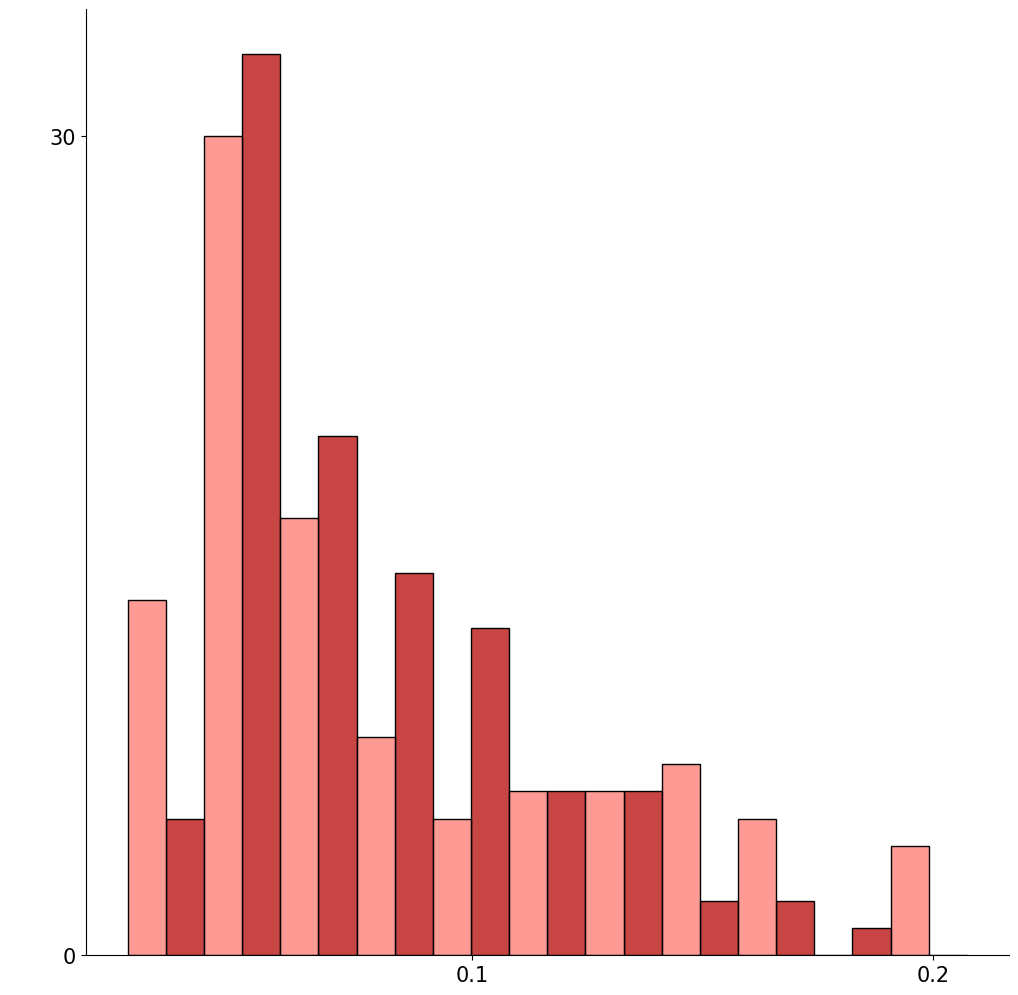

In [75]:
#plt.figure(figsize=(10,20))

sns.displot([ratio_radios, ratio_radios_generados], multiple="dodge", height=10, aspect=1, legend=False, palette = enmax_palette)
ax = plt.gca()

#ax.set_title("Radius P{} {}".format(p, dataset_name), fontsize=35)

#ax.set_xlabel("Radius", fontsize = 25)
ax.set_ylabel("  ", fontsize = 25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

ax.xaxis.set_major_locator(MaxNLocator(nbins=1))
ax.yaxis.set_major_locator(MaxNLocator(nbins=1))
# get the patches for each dataset
patches = ax.patches
l = int(len(patches)/2)
patches_radius = patches[:l]
patches_radius_generados = patches[l:]

# get the counts for ratio_radios
counts_radius = [patch.get_height() for patch in patches_radius]

# get the counts for ratio_radios_generados
counts_radius_generados = [patch.get_height() for patch in patches_radius_generados]

#ax.legend(labels=["Synthetic samples", "Real samples"], fontsize = 25)

In [76]:
np.dot(counts_radius, counts_radius_generados)/(np.linalg.norm(counts_radius)*np.linalg.norm(counts_radius_generados))

0.9412181208453927

In [61]:
values = [0.946306381992226, 0.8893526816459894, 0.9388776593013862]

# Mean
mean = statistics.mean(values)
print("Mean:", mean)

# Standard Deviation
std_dev = statistics.stdev(values)
print("Standard Deviation:", std_dev)

Mean: 0.9248455743132006
Standard Deviation: 0.0309613557942636


In [66]:
from scipy import stats

# Example cosine similarity score (replace with your actual score)
cosine_similarity_score = 0.946306381992226

# Define null hypothesis value (e.g., expected similarity score)
null_hypothesis_value = 1  # Adjust this value according to your hypothesis

# Perform one-sample t-test
t_statistic, p_value = stats.ttest_1samp(cosine_similarity_score, null_hypothesis_value)
print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: nan
p-value: nan


In [73]:
import numpy as np

# Example cosine similarity scores (replace with your actual scores)
cosine_similarity_scores = [0.946306381992226, 0.8893526816459894, 0.9388776593013862]

# Number of bootstrap samples
num_bootstrap_samples = 1000

# Generate bootstrap samples
bootstrap_scores = []
for _ in range(num_bootstrap_samples):
    bootstrap_sample = np.random.choice(cosine_similarity_scores, size=len(cosine_similarity_scores), replace=True)
    bootstrap_scores.append(np.mean(bootstrap_sample))

# Calculate statistics of interest
bootstrap_mean = np.mean(bootstrap_scores)
bootstrap_std = np.std(bootstrap_scores)
confidence_interval = np.percentile(bootstrap_scores, [5, 95])

# Assess fidelity
if confidence_interval[0] <= np.mean(cosine_similarity_scores) <= confidence_interval[1]:
    print("Observed cosine similarity score is consistent with the variability expected under bootstrapping.")
else:
    print("Observed cosine similarity score is not consistent with the variability expected under bootstrapping.")

print("Bootstrap Mean:", bootstrap_mean)
print("Bootstrap Standard Deviation:", bootstrap_std)
print("95% Confidence Interval:", confidence_interval)

Observed cosine similarity score is consistent with the variability expected under bootstrapping.
Bootstrap Mean: 0.9244782645014769
Bootstrap Standard Deviation: 0.014378619403961195
95% Confidence Interval: [0.90586101 0.94383014]


tortuosidad

c:\Users\User\anaconda3\envs\py_torch\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


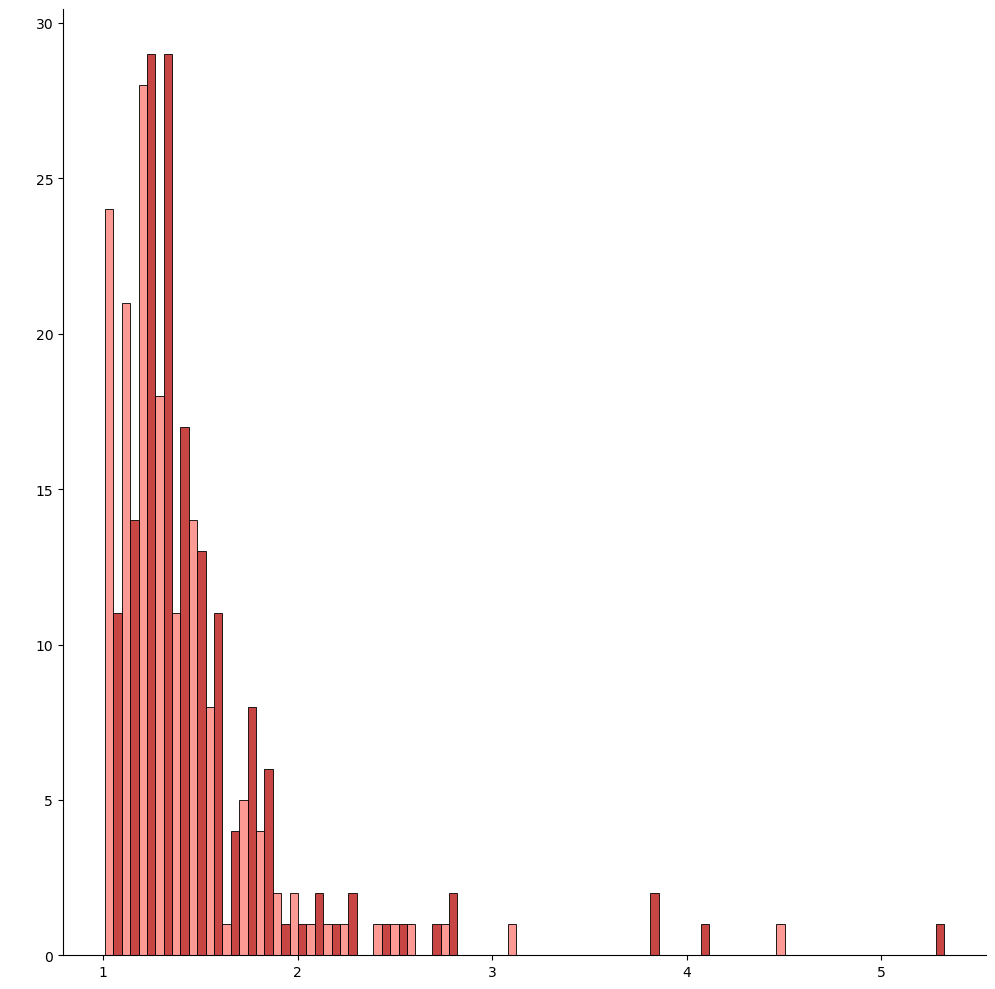

In [56]:
sns.displot([tortuosidad, tortuosidad_generados], multiple="dodge", height=10, aspect=1, legend=False, palette = enmax_palette, bins = 50)
ax = plt.gca()
#ax.legend(labels=["Synthetic Samples", "Real samples"], fontsize = 25)
#ax.set_title("Tortuosity P{} {}".format(p, dataset_name), fontsize=35)
#ax.set_xlabel("Tortuosity", fontsize = 25)
ax.set_ylabel(" ", fontsize = 15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


# get the patches for each dataset
patches = ax.patches
l = int(len(patches)/2)
patches_tortuosidad = patches[:l]
patches_tortuosidad_generados = patches[l:]

# get the counts for ratio_radios
counts_tortuosidad = [patch.get_height() for patch in patches_tortuosidad]

# get the counts for ratio_radios_generados
counts_tortuosidad_generados = [patch.get_height() for patch in patches_tortuosidad_generados]
#ax.xaxis.set_major_locator(MaxNLocator(nbins=1, prune='both'))


In [57]:
np.dot(counts_tortuosidad, counts_tortuosidad_generados)/(np.linalg.norm(counts_tortuosidad)*np.linalg.norm(counts_tortuosidad_generados))

0.9203178864932338

Largo total

c:\Users\User\anaconda3\envs\py_torch\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


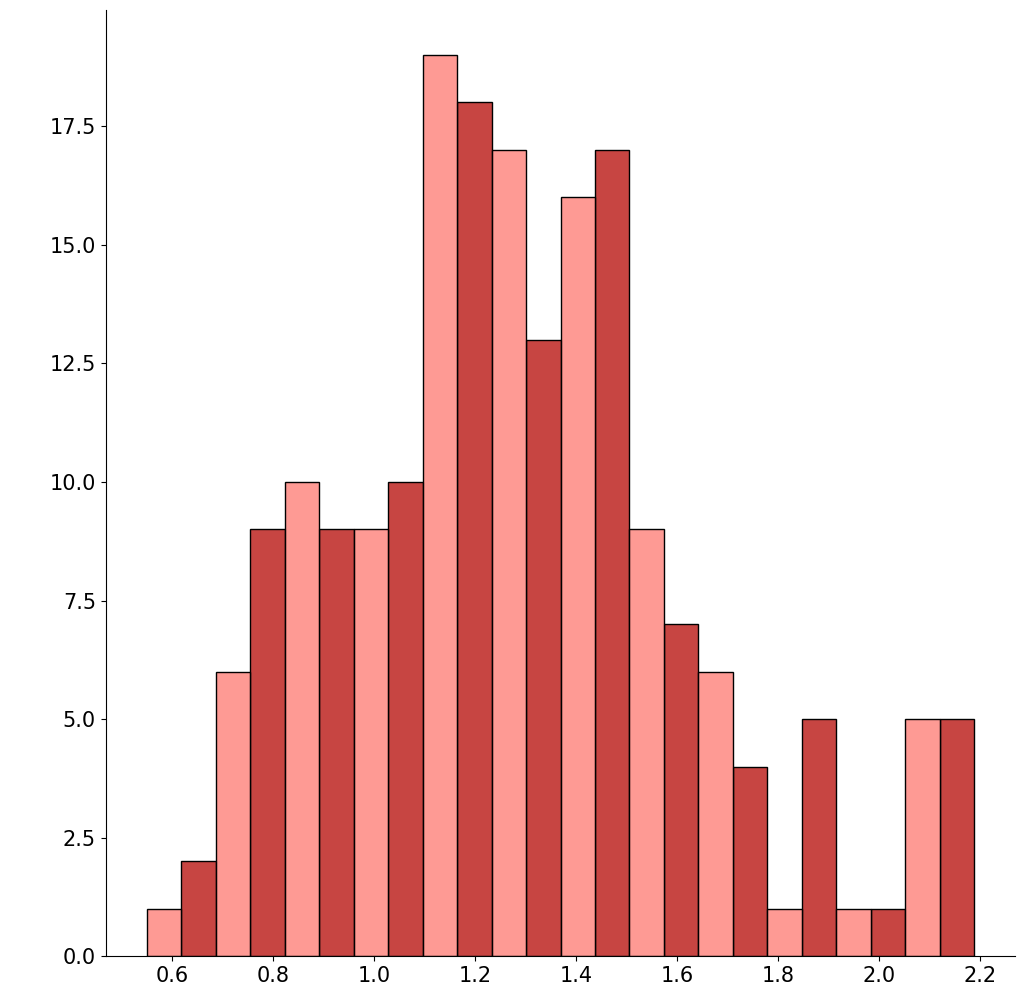

In [58]:
sns.displot([largo, largo_generados], multiple="dodge", height=10, aspect=1, legend=False, palette=enmax_palette)
ax = plt.gca()
#ax.legend(labels=["Synthetic Samples", "Real samples" ], fontsize = 25)
#ax.set_title("Length P{} {}".format(p, dataset_name), fontsize=35)

#ax.set_xlabel("Length", fontsize = 25)
ax.set_ylabel("  ", fontsize = 25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# get the patches for each dataset
patches = ax.patches
l = int(len(patches)/2)
patches_length = patches[:l]
patches_length_generados = patches[l:]



counts = [patch.get_height() for patch in patches]
# get the counts for ratio_radios
counts_length = [patch.get_height() for patch in patches_length]

# get the counts for ratio_radios_generados
counts_length_generados = [patch.get_height() for patch in patches_length_generados]

In [59]:
np.dot(counts_length, counts_length_generados)/(np.linalg.norm(counts_length)*np.linalg.norm(counts_length_generados))

0.9786913224897238